In [ ]:
# module scikit-learn spécialisé dans l'analyse de graphe
!pip install scikit-network

Defaulting to user installation because normal site-packages is not writeable


Import des packages nécessaires au clustering :

In [ ]:
# permet de manipuler des matrices creuses, beaucoup plus efficace en complexité
from scipy import sparse

import numpy as np

import random

#le package de scikit-network spécialisé dans le clustering de graphes
import sknetwork.clustering

# méthode permettant de créer un graphe "visuel" à partir d'une matrice d'adjacence
from sknetwork.visualization import svg_graph

# méthode permettant d'afficher les graphes obtenus avec svg_graph
from IPython.display import SVG

Import du graphe des profils Twitter sous la forme d'une matrice d'adjacence (scipy sparse matrix)

La matrice d'adjacence n'a besoin d'être renseignée que sur une de ses moitiés

In [ ]:
adjacence = np.eye(10)
random.seed = 10
for i in range(10) :
    adjacence[random.randint(0,9),random.randint(0,9)] = 1
adjacence = sparse.csr_matrix(adjacence)

Visualisation du graphe :

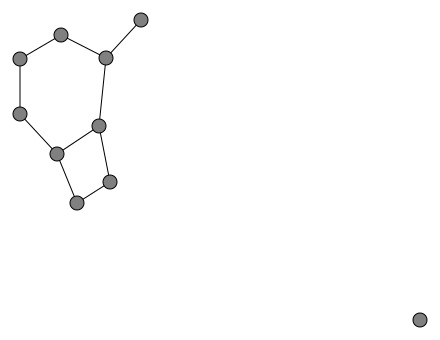

In [ ]:
# Pour afficher le graphe, la matrice d'adjacence doit nécessairement être une
# sparse matrix de scipy
image = svg_graph(adjacence)
SVG(image)

1.   L'algorithme de Louvain

L'algorithme de Louvain est un algorithme itératif de clustering de graphe.

Le but de l'algorithme est de choisir le partitionnement de graphe qui maximise une certaine fonction de gain Q appelée modularité.

Cet algorithme est composé de deux phases.

(1) Dans la première phase, on assigne une communauté à chaque noeud du graphe. Puis, on parcourt chaque noeud et on le met dans la communauté qui augmente le plus la fonction de gain Q. La première phase s'arrête lorsqu'aucun mouvement d'un individu ne permet d'augmenter Q.

(2) Dans la deuxième phase, on construit un nouveau réseau dans lequel les noeuds correspondent aux communautés construites précédemment.

Une fois ceci fait, on réitère ces deux phases sur ce nouveau réseau, puis on arrête l'algorithme lorsqu'on ne peut plus augmenter Q.



Pour plus d'information, veuillez lire le document suivant : https://arxiv.org/pdf/0803.0476v2.pdf

In [ ]:
from sknetwork.clustering import Louvain

adjacence_louvain = adjacence.copy()

louvain = Louvain(random_state=0)

# louvain.fit_transform fit la matrice d'adjacence avec la méthode de Louvain et renvoie
# les labels de clustering correspondants
labels_louvain = louvain.fit_transform(adjacence_louvain)

print(labels_louvain)

[1 0 1 0 3 4 0 2 2 3]


Affichage du graphe avec les clusters obtenus par l'algorithme de Louvain :

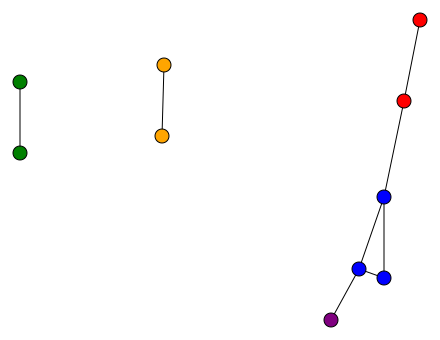

In [ ]:
image_louvain = svg_graph(adjacence_louvain,labels=labels_louvain)
SVG(image_louvain)

2. Clustering spectral


L'algorithme de Clustering spectral est un algorithme de clustering de graphe utilisant la méthode des k-means.

Cette méthode des k-means a été vue en cours, mais ne peut pas s'appliquer directement à un graphe, qui, contrairement à un nuage de points par exemple, n'a pas de portée géométrique.

(1) Pour appliquer la méthode des k-means, on considère alors la matrice de Laplace. Pour rappel, cette matrice est définie par :
$$ L = D-A \\ ~\mathrm{où} ~A ~\mathrm{est ~la ~matrice ~d'adjacence, ~et } ~D ~\mathrm{est ~une~ matrice~ diagonale~ où ~chaque ~élément~ de~ la~ diagonale~ est ~la ~somme ~des ~éléments ~de ~la~ ligne~ de}~ A ~\mathrm{correspondante}$$

(2) Une fois cette matrice calculée, on détermine les vecteurs propres de cette matrice. On sélectionne alors les k vecteurs propres (où k est le nombre de clusters voulus) correspondants aux k premières valeurs propres (rangées dans par ordre croissant).

(3) Enfin, il suffit d'appliquer l'algorithme des k-means à ces k vecteurs propres.


On remarquera que dans cet algorithme, contrairement aux deux autres algorithmes présentés, on a pas besoin de spécifier le nombre de clusters voulus.


Pour plus d'information, veuillez vous référer à la page Wikipédia correspondante : https://en.wikipedia.org/wiki/Spectral_clustering

In [ ]:
# la méthode KMeans correspond bien à du clustering spectral, et non à le méthode des k-means,
# qui n'a pas de sens pour un graphe
from sknetwork.clustering import KMeans

adjacence_spectral = adjacence.copy()

kmeans = KMeans(n_clusters=4)

# kmeans.fit_transform fit la matrice d'adjacence avec la méthode de clustering spectral
# et renvoie les labels de clustering correspondants
labels_spectral = kmeans.fit_transform(adjacence_spectral)

print(labels_spectral)

[0 2 1 0 0 3 0 1 1 2]


C:\Users\Florent\AppData\Roaming\Python\Python36\site-packages\sknetwork\utils\check.py:314: Warning: The dimension of the embedding cannot exceed 9.Changed accordingly.
  "Changed accordingly.".format(n_min)))


Affichage du graphe avec les clusters obtenus par l'algorithme de clustering spectral :

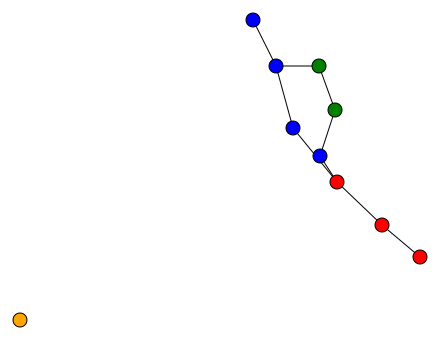

In [ ]:
image_spectral = svg_graph(adjacence_spectral,labels=labels_spectral)
SVG(image_spectral)

3. Clustering par propagation d'étiquette ("label propagation")

L'algorithme de Clustering par "label propagation" est un algorithme itératif de clustering de graphe.

Cet algorithme consiste à assigner une "étiquette" aux différents noeuds, puis, pour chaque noeud, à changer les différentes "étiquettes" en étudiant celles du voisinage de ce noeud.

Vous trouverez ci-dessous les étapes de cet algorithme. Par la suite, on notera $ t $ l'itération de l'algorithme et $C_x(t) $ l'étiquette du noeud $ x $ à l'itération $ t $.

(1) On initialise tout d'abord les labels de chaque noeuds en leur donnant une valeur différente : $$ \forall x, C_x(0) = x .$$

(2) On fixe $ t = 1$

(3) On considère ensuite un ordre aléatoire $ X $ des noeuds du graphe.

(4) Pour chaque noeud $ x $ dans l'ordre défini par $ X $, on met à jour le label du noeud $ x $. $ C_x(t) $ correspond alors au label le plus fréquent dans les voisins de $ x $. En cas d'égalité entre plusieurs labels, on en choisit un aléatoirement.

(5) Enfin, si chaque noeud possède une étiquette que le nombre maximum de ses voisins possède, alors l'algorithme s'arrête. Sinon, $ t = t+1$ et on retourne en (3).

$ \\ $

Pour plus d'information, veuillez consulter le document suivant : https://arxiv.org/pdf/0709.2938.pdf

In [ ]:
from sknetwork.clustering import PropagationClustering

propagation = PropagationClustering(n_iter=-1)

adjacence_propagation = adjacence.copy()

# propagation.fit_transform fit la matrice d'adjacence avec la méthode de propagation
# et renvoie les labels de clustering correspondants
labels_propagation = propagation.fit_transform(adjacence_propagation)

print(labels_propagation)

[0 1 0 2 3 4 2 5 5 1]


Affichage du graphe avec les clusters obtenus par l'algorithme de propagation :

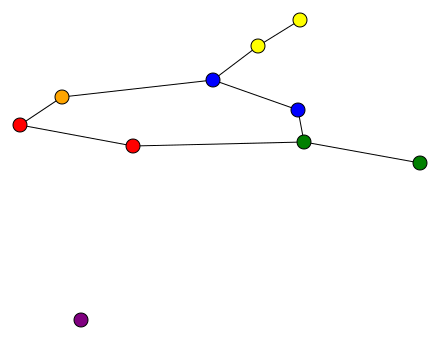

In [ ]:
image_propagation = svg_graph(adjacence_propagation,labels=labels_propagation)
SVG(image_propagation)